In [1]:
import torch
from IPython import display
from d2l import torch as d2l

In [2]:
batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)

In [3]:
#初始化模型参数
num_inputs = 784
num_outputs = 10

W = torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)
print(W.shape)
print(b.shape)

torch.Size([784, 10])
torch.Size([10])


In [4]:
#定义softmax操作
def softmax(X):
    exp_X = torch.exp(X)
    partition = exp_X.sum(1,keepdim=True)   #定义规范化常数
    return exp_X / partition

X = torch.normal(0,1,(2,5))
print(X)
X_softmax = softmax(X)
print(X_softmax)
X_softmax.sum(1)


tensor([[ 0.1385,  0.5693,  0.4449,  0.4143, -1.6381],
        [ 1.0118,  0.5086, -0.0136,  0.8531,  0.0413]])
tensor([[0.1857, 0.2858, 0.2523, 0.2447, 0.0314],
        [0.3129, 0.1892, 0.1122, 0.2670, 0.1186]])


tensor([1.0000, 1.0000])

softamx()操作中并没有采取措施防止非常大或非常小的数据出现数值上（下）溢

In [5]:
#如何通过网络映射到输出
print(W.shape[0])
def net(X):
    return softmax(torch.matmul(X.reshape((-1,W.shape[0])),W) + b)

784


In [6]:
#定义损失函数
def cross_entropy(y_hat,y): #交叉熵函数，使用负对数似然
    return -torch.log(y_hat[range(len(y_hat)),y])   #y_hat为样本数据预测结果，y为y_hat中样本所属的标签

y = torch.tensor([0,2])          
y_hat = torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
cross_entropy(y_hat,y)

tensor([2.3026, 0.6931])

In [7]:
def accuracy(y_hat,y):  #@save
    """"计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis = 1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

print(accuracy(y_hat,y)) #预测对的样本数量为1.0个
accuracy(y_hat,y) / len(y)#分类精度

1.0


0.5

In [8]:


def evaluate_accuracy(net,data_iter):   #@save
    """"计算指定数据集上模型的精度"""
    if isinstance(net,torch.nn.Module):
        net.eval()  #将模型设置为评估模式
    metric = d2l.Accumulator(2) #正确预测数，预测总数
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return metric[0] / metric[1]

evaluate_accuracy(net,test_iter)

0.103

isinstance(object, classinfo) 函数来判断一个对象是否是一个已知的类型，类似 type().如果对象的类型与参数二的类型（classinfo）相同则返回 True，否则返回 False。
metric = d2l.Accumulator(2)为累加器

In [9]:
#训练
def train_epoch_ch3(net,train_iter,loss,updater):
    """训练模型一个迭代周期"""
    #将模型设置为训练模式
    if isinstance(net,torch.nn.Module):
        net.train()
    #训练损失总和，训练准确度总和，样本数
    metric = d2l.Accumulator(3)
    for X,y in train_iter:
        #计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            #使用pytorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            #使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    #返回训练损失和训练精度
    return metric[0]/ metric[2],metric[1]/ metric[2]

In [10]:
def train_ch3(net,train_iter,loss,num_epochs,updater):  #@save
    """"训练模型"""
    animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0.3,0.9],legend=['train loss','train acc','test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net,train_iter,loss,updater)
        test_acc = evaluate_accuracy(net,test_iter)
        animator.add(epoch + 1,train_metrics + (test_acc,))
    train_loss,train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7,train_acc
    assert test_acc <= 1 and test_acc > 0.7,test_acc

assert进行异常处理，若表达式真值不为1，则会因发AssertionError,抛出一个错误

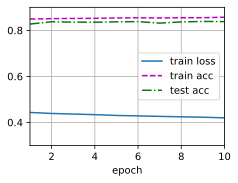

In [12]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W,b],lr,batch_size)

num_epochs = 10
train_ch3(net,train_iter,cross_entropy,num_epochs,updater)

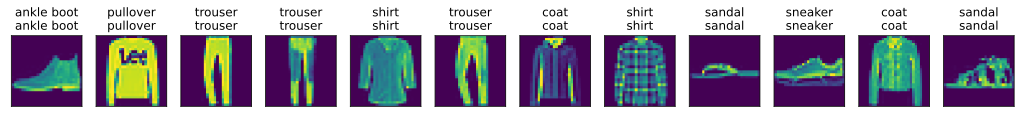

In [16]:
#测试数据样本预测

def predict_ch3(net,test_iter,n = 12):
    """预测标签"""
    for X,y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis = 1))
    titles = [true + '\n' + pred for true,pred in zip(trues,preds)]
    d2l.show_images(X[0:n].reshape((n,28,28)),1,n,titles = titles[0:n])

predict_ch3(net,test_iter)